In [8]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import PIL

In [2]:
import torch
import numpy as np
from diffusers import ControlNetModel, StableDiffusionControlNetInpaintPipeline
from diffusers.utils import load_image, make_image_grid

# load ControlNet
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16)

# pass ControlNet to the pipeline
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

# load base and mask image
init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png")

# prepare control image
def make_inpaint_condition(init_image, mask_image):
    init_image = np.array(init_image.convert("RGB")).astype(np.float32) / 255.0
    mask_image = np.array(mask_image.convert("L")).astype(np.float32) / 255.0

    assert init_image.shape[0:1] == mask_image.shape[0:1], "image and image_mask must have the same image size"
    init_image[mask_image > 0.5] = -1.0  # set as masked pixel
    init_image = np.expand_dims(init_image, 0).transpose(0, 3, 1, 2)
    init_image = torch.from_numpy(init_image) # we need Torch Tensor to processing later
    return init_image

control_image = make_inpaint_condition(init_image, mask_image)

/workspace/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 7/7 [00:41<00:00,  5.99s/it]


In [52]:
a = np.arange(5)
b = np.arange(5) + 1
a[b > 3] = -1

In [54]:
b

array([1, 2, 3, 4, 5])

In [53]:
a

array([ 0,  1,  2, -1, -1])

In [58]:
c = np.array(init_image.convert('RGB')).astype(np.float32) / 255.

In [61]:
c.shape

(512, 512, 3)

In [68]:
d = np.random.randint(1, 5, size=(1, 2, 3))
d

array([[[3, 4, 1],
        [1, 1, 3]]])

In [69]:
d.shape

(1, 2, 3)

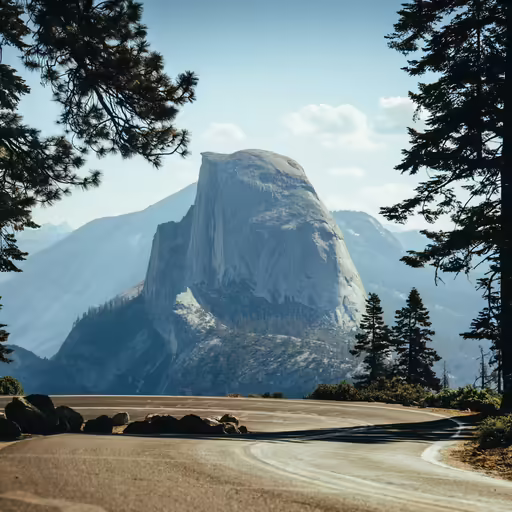

In [3]:
init_image

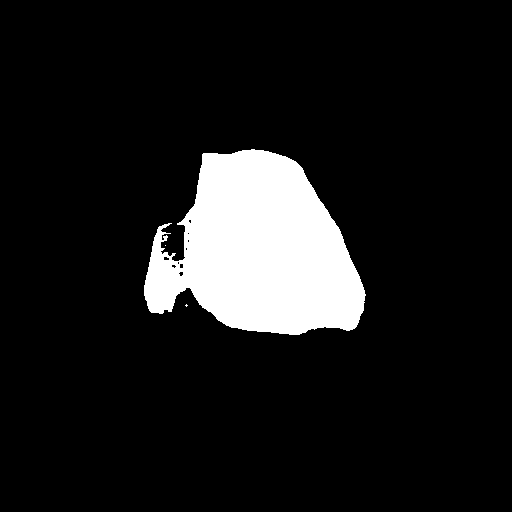

In [4]:
mask_image

100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


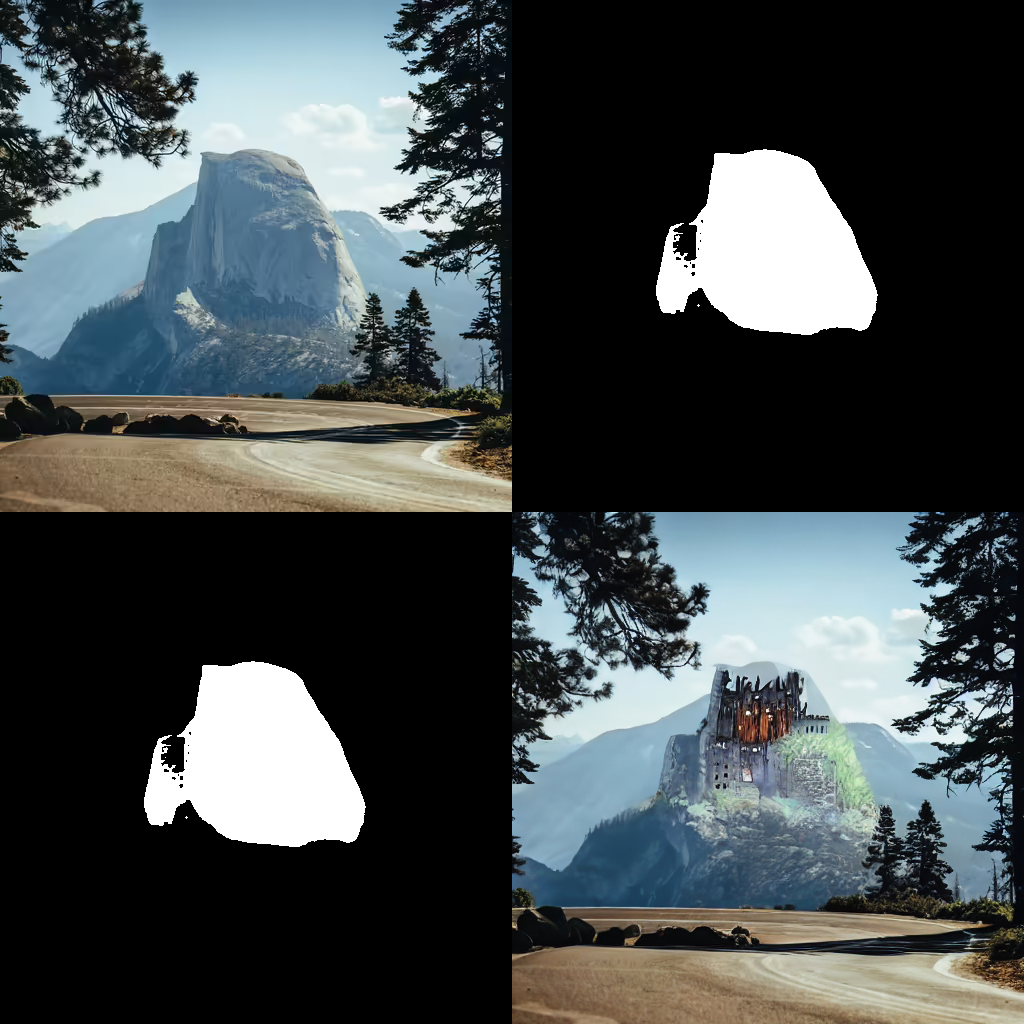

In [9]:
prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, control_image=control_image).images[0]
make_image_grid([init_image, mask_image, PIL.Image.fromarray(np.uint8(control_image[0][0])).convert('RGB'), image], rows=2, cols=2)

In [12]:
control_image.size()

torch.Size([1, 3, 512, 512])

In [15]:
control_image[0][0].size()

torch.Size([512, 512])

In [70]:
control_image[0][0]

tensor([[0.0275, 0.1059, 0.1725,  ..., 0.0000, 0.0000, 0.0000],
        [0.0039, 0.0706, 0.1216,  ..., 0.0039, 0.0000, 0.0000],
        [0.0078, 0.0549, 0.0941,  ..., 0.0039, 0.0039, 0.0039],
        ...,
        [0.3843, 0.3765, 0.3686,  ..., 0.7098, 0.7020, 0.6941],
        [0.4353, 0.4196, 0.3765,  ..., 0.7608, 0.7529, 0.7490],
        [0.4824, 0.4549, 0.4039,  ..., 0.8235, 0.8196, 0.8196]])

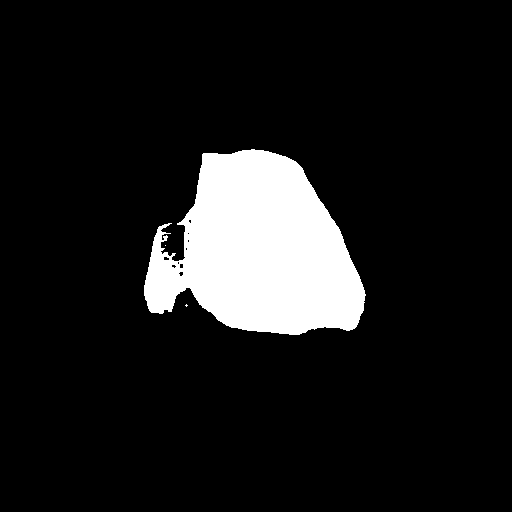

In [77]:
PIL.Image.fromarray(np.uint8(control_image[0][0])).convert('RGB')

vae/diffusion_pytorch_model.safetensors not found
100%|██████████| 40/40 [00:06<00:00,  6.35it/s]


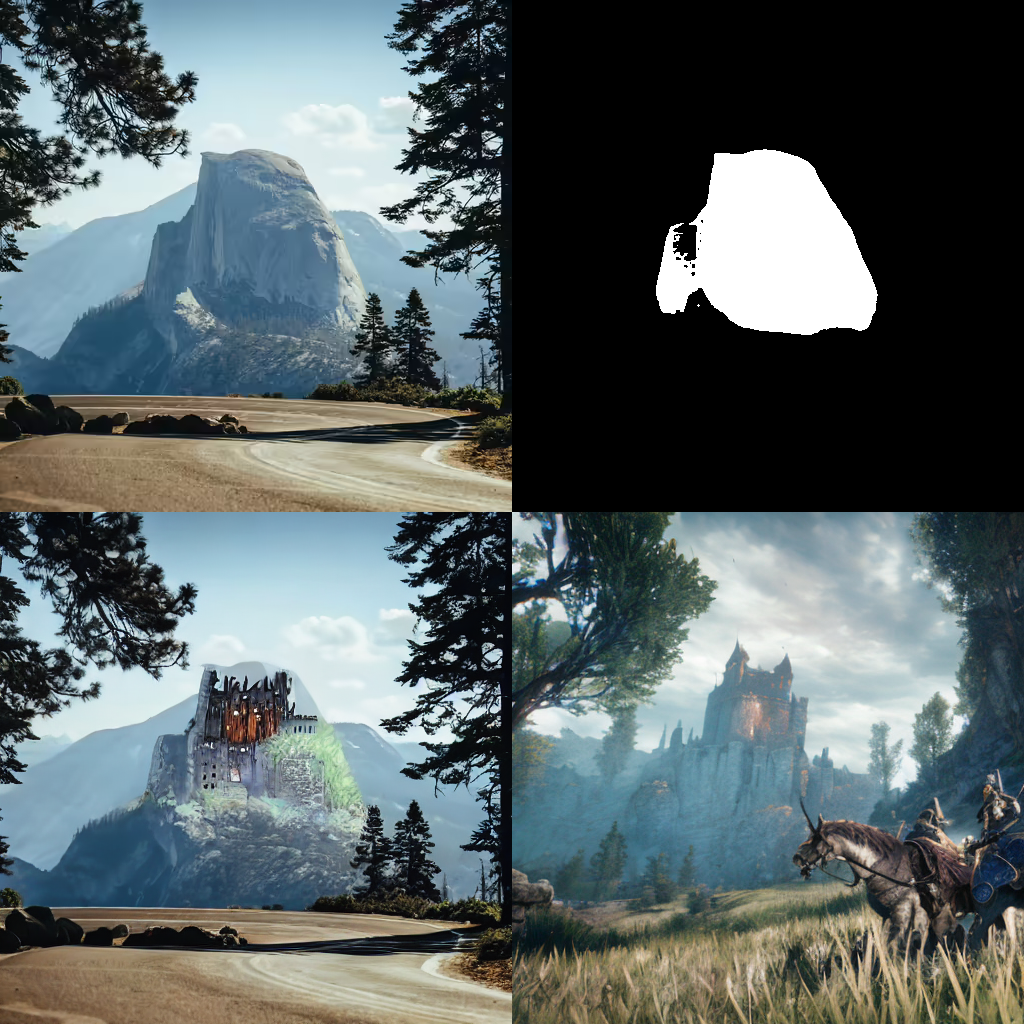

In [79]:
from diffusers import AutoPipelineForImage2Image

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "nitrosocke/elden-ring-diffusion", torch_dtype=torch.float16,
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

prompt = "elden ring style castle" # include the token "elden ring style" in the prompt
negative_prompt = "bad architecture, deformed, disfigured, poor details"

image_elden_ring = pipeline(prompt, negative_prompt=negative_prompt, image=image).images[0]
make_image_grid([init_image, mask_image, image, image_elden_ring], rows=2, cols=2)